# MPSC EDA
<hr >

In this notebook we will go thru the data

## Table Of Content
<hr >

1. [Introduction](#Introduction)
2. [Imports and Load](#Imports-and-Load)
3. [Diving into Data](#Diving-into-Data)

## Introduction
<hr >

### [Data Description](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data)
>In this competition, you will predict the sale price of a listing based on information a user provides for this listing.
>
>#### Data fields
>##### train.tsv, test.tsv
>The files consist of a list of product listings. These files are tab-delimited.
> 1. **train_id** or **test_id** - the id of the listing
> 2. **name** - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
> 3. **item_condition_id** - the condition of the items provided by the seller
> 4. **category_name** - category of the listing
> 5. **brand_name**
> 6. **price** - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
> 7. **shipping** - 1 if shipping fee is paid by seller and 0 by buyer
> 8. **item_description** - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
<hr >

### [Evaluation](https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview/evaluation)

>The evaluation metric for this competition is [Root Mean Squared Logarithmic Error](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError).
>
>The RMSLE is calculated as
>
>$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$
>
>Where:
>
>- \\(\epsilon\\) is the RMSLE value (score)
>- \\(n\\) is the total number of observations in the (public/private) data set,
>- \\(p_i\\) is your prediction of price, and
>- \\(a_i\\) is the actual sale price for \\(i\\).
>- \\(\log(x)\\) is the natural logarithm of \\(x\\)
<hr >

## Imports and Load
<hr >

Next step is to import the libraries requierd for our analysis, define usefull constents, then load the data and make quick overview
<hr >

In [1]:
import pandas as pd # for loading data and display tabualer data
import numpy as np # for applying mathmatical operations
import matplotlib.pyplot as plt # for creating interactive visualizations
import seaborn as sns # data visualization library based on matplotlib

In [2]:
TRAIN_FILE_PATH = './train.tsv' # the training file path, change the path if you have it in another dir
TARGET = 'price'

<hr >

**Note:**
>make sure you have **train.tsv** file, you can find it in this [link](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data?select=train.tsv.7z), you need to sign in and accept the rules.

In [3]:
df = pd.read_table(TRAIN_FILE_PATH)
df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


<hr >

**Noticed from the table above:**
> - we have about 1.5M data points
> - train_id can be droped since its redundant column
> - category_name has the format "$a$/$b$/$c$", ex: "Women/Jewelry/Necklaces".
>
> > where:
> > $a$ is **main category**, $b$ is **sub_1 category** and $c$ is **sub_2 category**
> >
> > this hipothesis needs more investigation
> >
> > **update**:
> > from below testing we found that some data points dont follow this rule

In [4]:
# drop train_id
df.drop('train_id', axis=1, inplace=True)
df.columns

Index(['name', 'item_condition_id', 'category_name', 'brand_name', 'price',
       'shipping', 'item_description'],
      dtype='object')

In [5]:
# lets check the category_name and if our hypothesis about "a/b/c" format is valid for all non-na values
series_catname = df['category_name'].dropna()
series_istrue = series_catname.apply(lambda x: len(x.split('/'))) == 3
if (series_istrue).all():
    print("[+] correct hypothesis: all category_name points has the \"a/b/c\" format")
else:
    print("[-] invalid hypothesis: needs more investigation")

[-] invalid hypothesis: needs more investigation


In [6]:
display(series_catname[series_istrue == False])
series_catname[series_istrue == False].apply(lambda x: len(x.split('/'))).drop_duplicates()

239        Electronics/Computers & Tablets/iPad/Tablet/eB...
742        Electronics/Computers & Tablets/iPad/Tablet/eB...
1700       Electronics/Computers & Tablets/iPad/Tablet/eB...
2828                 Sports & Outdoors/Exercise/Dance/Ballet
2923       Electronics/Computers & Tablets/iPad/Tablet/eB...
                                 ...                        
1482118                    Men/Coats & Jackets/Flight/Bomber
1482266              Sports & Outdoors/Exercise/Dance/Ballet
1482283    Electronics/Computers & Tablets/iPad/Tablet/eB...
1482387    Electronics/Computers & Tablets/iPad/Tablet/eB...
1482442              Sports & Outdoors/Exercise/Dance/Ballet
Name: category_name, Length: 4389, dtype: object

239     5
2828    4
Name: category_name, dtype: int64

<hr >

**Noticed from the series above:**
> - about 0.3% of the data points **don't** follow "$a$/$b$/$c$" format in **category_name**, insted we can find more two catigories "$a$/$b$/$c$/$d$" and "$a$/$b$/$c$/$d$/$e$", and these are the only possible **category_name** formats it can be
>
> > ex. "Men/Coats & Jackets/Flight/Bomber"
>
> >how can we deal with these data points:
> >1. we can just stick with the first 3 catigores, but this means we will loss some information
> >
> > > ex. "Men/Coats & Jackets/Flight/Bomber" \-\> "Men/Coats & Jackets/Flight"
> >
> >
> >2. we can combine last sub categories "$a$/$b$/$c$-$d$-$e$", maybe the best soliotion, no information loss and memory friendly
> >
> > > ex. "Electronics/Computers & Tablets/iPad/Tablet/eBook Readers" \-\> "Electronics/Computers & Tablets/iPad-Tablet-eBook Readers"
> >
> >3. we can convert all **category_name** fields to have the format "$a$/$b$/$c$/$d$/$e$" and replace missing categories with the word "Other", but this will consume more memory
> >
> > > ex. "Women/Jewelry/Necklaces" \-\> "Women/Jewelry/Necklaces/Other/Other"

## Diving into Data
<hr >

In [7]:
#Lets start with check missing values and fillna
display(df.isna().sum())

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

**Noticed from the series above:**
> **category_name**, **brand_name** and **item_description** have missing values

In [8]:
# fill-na with resonable values for each column
df['category_name'] = df['category_name'].fillna('Other/Other/Other')
df['brand_name'] = df['brand_name'].fillna('Other')
df['item_description'] = df['item_description'].fillna('No description yet')

In [9]:
# split category_name to 3 subs
df['main_cat'] = df['category_name'].apply(lambda x: x.split('/', maxsplit=2)[0])
df['sub1_cat'] = df['category_name'].apply(lambda x: x.split('/', maxsplit=2)[1])
df['sub2_cat'] = df['category_name'].apply(lambda x: x.split('/', maxsplit=2)[2])

### make some analysis and plot charts

<AxesSubplot:ylabel='Frequency'>

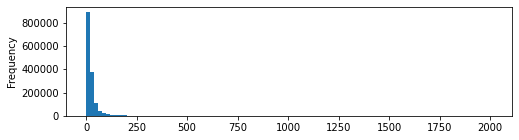

In [10]:
# First thing we can plot is the Target distribution
plt.figure(figsize=(8, 2))
df[TARGET].plot.hist(bins=100)

**We can see from the above chart:**
> - the ranges of the Target **price** lies bettwen 0 and about 2000
> - items with high prices are less frequent and almost all items lies in the (0, 250( range

<AxesSubplot:xlabel='main_cat', ylabel='price'>

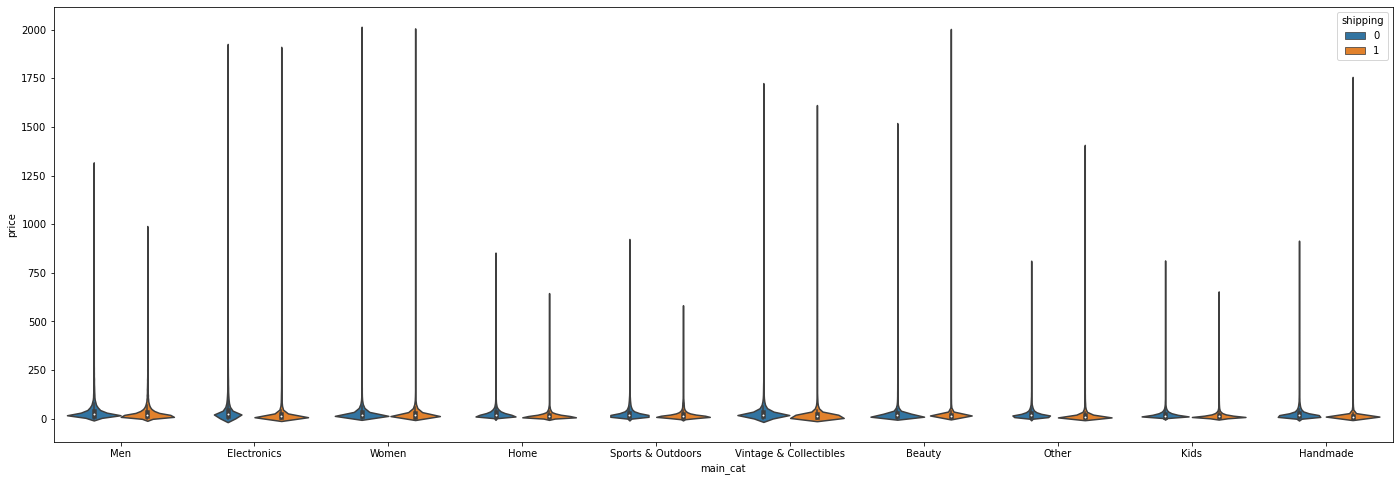

In [11]:
# plot the prices of each main category and shipping fees
plt.figure(figsize=(24, 8))
sns.violinplot(data=df, x='main_cat', hue='shipping', y='price')

**Notes:**
> - this chart is hardly describable because of outlaiers in the Target values
>> how can we deal with this issue
>> 1. we can drop these outlaiers, but we will loss some of the data points
>> 2. we can rescale the Target values, will use $log(x + 1)$ for this manner

<AxesSubplot:xlabel='main_cat', ylabel='log1p_price'>

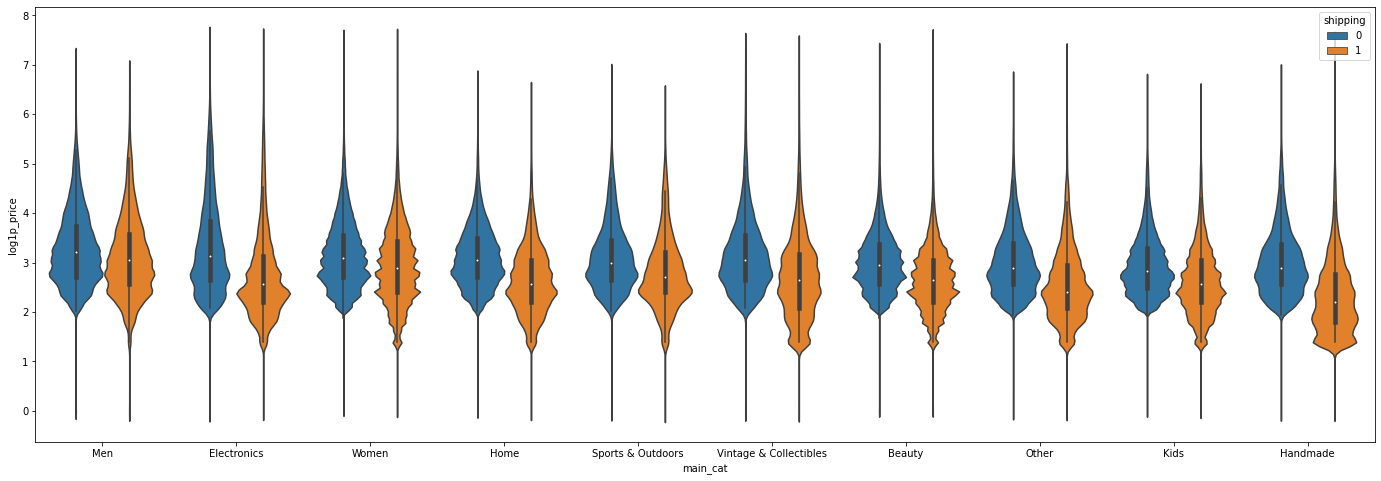

In [12]:
# plot the log of prices of each main category and shipping fees
df['log1p_price'] = np.log1p(df['price'])
plt.figure(figsize=(24, 8))
sns.violinplot(data=df, x='main_cat', hue='shipping', y='log1p_price')

**Now we can see more clear results:**
> - we can see the scaled Target distribution for each main category
> - when add **shipping fees** the mean price go lower and thats true for all main categories

### price values needs more to discuss

In [13]:
df.groupby('price')['name'].count()

price
0.0         874
3.0       18703
4.0       16139
5.0       31502
5.5          33
          ...  
1999.0        1
2000.0        6
2004.0        1
2006.0        1
2009.0        1
Name: name, Length: 828, dtype: int64

<hr >

**Noticed from the table above:**
> - there are some item with price of \$0, are they realy free items or could it be somthing else
> - there are only 828 unique values for price in this training csv file
>> that makes us thinking of solving this problem as **classification** then converts the predictions to real numbers
>>
>> how can we did it:
>>
>> lets say we have a model that predict probabilities for each class (classification)
>>
>> and the classes are {1, 2, 3}
>> if the model prediction was {1: 0.2, 2: 0.3, 3: 0.5} then we can convert these values to real number $1 * 0.2 + 2 * 0.3 + 3 * 0.5 = 2.3$